In [209]:
import pandas as pd
import numpy as np
import ast
import os
from datetime import datetime
import re
import string
import nltk
from nltk.corpus import stopwords, opinion_lexicon
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('opinion_lexicon')
# Load the partial data
df = pd.read_csv('./data/raw/steam_games_partial.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jadoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jadoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jadoo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\Jadoo\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [210]:
# Display the first few rows of the DataFrame
df.head()

# Get a concise summary of the DataFrame
df.info()

# Get descriptive statistics for numerical columns
df.describe()

# Check for missing values
df.isnull().sum()

# Check for dimensions
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   type                     12120 non-null  object
 1   name                     12119 non-null  object
 2   steam_appid              12120 non-null  int64 
 3   required_age             12120 non-null  int64 
 4   is_free                  12120 non-null  bool  
 5   detailed_description     10785 non-null  object
 6   about_the_game           10779 non-null  object
 7   short_description        10800 non-null  object
 8   supported_languages      10744 non-null  object
 9   header_image             12120 non-null  object
 10  capsule_image            12120 non-null  object
 11  capsule_imagev5          12120 non-null  object
 12  website                  3820 non-null   object
 13  pc_requirements          12120 non-null  object
 14  mac_requirements         12120 non-nul

(12120, 43)

In [211]:
# Define regex patterns for DLCs and Playtests
patterns = ['DLC', 'Playtest', 'Early Access', 'Sex']

# Use regex to filter out rows where 'name' or 'type' contains any of the patterns
df_cleaned = df[~df['name'].str.contains('|'.join(patterns), case=False, na=False)]
df_cleaned = df_cleaned[~df_cleaned['type'].str.contains('|'.join(patterns), case=False, na=False)]

# Check for missing values
missing_values = df_cleaned.isnull().sum()
print("Missing values in each column:")
print(df_cleaned.columns)

# Drop columns with more than 2000 missing values
columns_to_drop = ['type', 'steam_appid', 'required_age', 'is_free', 'about_the_game','supported_languages', 'header_image', 'capsule_image', 
                   'capsule_imagev5', 'website', 'pc_requirements', 'mac_requirements','linux_requirements', 'developers', 'package_groups', 
                   'platforms', 'categories', 'screenshots', 'movies', 'support_info', 'background', 'background_raw', 'legal_notice', 'fullgame', 'demos', 
                   'controller_support', 'reviews', 'dlc', 'achievements','price_overview', 'packages', 'ext_user_account_notice', 'metacritic', 
                   'recommendations', 'drm_notice']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Display the columns that were dropped
print("Dropped columns:")
print(columns_to_drop)

# Fill missing values using .loc to avoid the SettingWithCopyWarning
df_cleaned.loc[:, 'detailed_description'] = df_cleaned['detailed_description'].fillna('')
df_cleaned.loc[:, 'short_description'] = df_cleaned['short_description'].fillna('')

# Select relevant features, including 'metacritic'
columns_to_keep = ['name', 'detailed_description', 'short_description', 'content_descriptors', 'genres', 'release_date', 'ratings', 'publishers']
df_selected = df_cleaned[columns_to_keep]


Missing values in each column:
Index(['type', 'name', 'steam_appid', 'required_age', 'is_free',
       'detailed_description', 'about_the_game', 'short_description',
       'supported_languages', 'header_image', 'capsule_image',
       'capsule_imagev5', 'website', 'pc_requirements', 'mac_requirements',
       'linux_requirements', 'developers', 'publishers', 'package_groups',
       'platforms', 'categories', 'genres', 'screenshots', 'movies',
       'release_date', 'support_info', 'background', 'background_raw',
       'content_descriptors', 'ratings', 'legal_notice', 'fullgame', 'demos',
       'controller_support', 'reviews', 'dlc', 'achievements',
       'price_overview', 'packages', 'ext_user_account_notice', 'metacritic',
       'recommendations', 'drm_notice'],
      dtype='object')
Dropped columns:
['type', 'steam_appid', 'required_age', 'is_free', 'about_the_game', 'supported_languages', 'header_image', 'capsule_image', 'capsule_imagev5', 'website', 'pc_requirements', 'mac_re

In [212]:
# Normalize the genres column
def extract_genres(genre_list):
    try:
        genre_list = ast.literal_eval(genre_list)
        return ', '.join([genre['description'] for genre in genre_list])
    except (ValueError, SyntaxError):
        return ''

# Apply the genre extraction using .loc
df_selected.loc[:, 'genres'] = df_selected['genres'].apply(extract_genres)

# Parse the release_date column
def parse_release_date(date_info):
    try:
        date_dict = eval(date_info)
        coming_soon = int(date_dict.get('coming_soon', False))
        date = date_dict.get('date', '')

        if date.lower() in ['coming soon', 'to be announced']:
            return pd.Series({'coming_soon': 1, 'release_date': pd.NaT})

        if date:
            try:
                parsed_date = pd.to_datetime(date)
                return pd.Series({
                    'coming_soon': coming_soon,
                    'release_date': parsed_date
                })
            except:
                pass

        return pd.Series({'coming_soon': coming_soon, 'release_date': pd.NaT})
    except:
        return pd.Series({'coming_soon': 0, 'release_date': pd.NaT})

# Apply the function
df_selected[['coming_soon', 'release_date']] = df_selected['release_date'].apply(parse_release_date)

# Create year, month, day columns using .loc
df_selected.loc[:, 'release_year'] = df_selected['release_date'].dt.year.fillna(0).astype(int)
df_selected.loc[:, 'release_month'] = df_selected['release_date'].dt.month.fillna(0).astype(int)
df_selected.loc[:, 'release_day'] = df_selected['release_date'].dt.day.fillna(0).astype(int)
df_selected.loc[:, 'release_quarter'] = df_selected['release_date'].dt.quarter.fillna(0).astype(int)

# Create is_released column using .loc
current_date = datetime.now()
df_selected.loc[:, 'is_released'] = (df_selected['release_date'].notna() & (df_selected['release_date'] <= current_date)).astype(int)

# Ensure coming_soon is 0 or 1 using .loc
df_selected.loc[:, 'coming_soon'] = df_selected['coming_soon'].fillna(0).astype(int)

C:\Users\Jadoo\AppData\Local\Temp\ipykernel_20652\4228258195.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[['coming_soon', 'release_date']] = df_selected['release_date'].apply(parse_release_date)
C:\Users\Jadoo\AppData\Local\Temp\ipykernel_20652\4228258195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, 'release_year'] = df_selected['release_date'].dt.year.fillna(0).astype(int)
C:\Users\Jadoo\AppData\Local\Temp\ipykernel_20652\4228258195.py:41: SettingWithCopyWarni

In [213]:
# Extract descriptors for sentiment analysis
def extract_descriptors(ratings):
    try:
        ratings_dict = ast.literal_eval(ratings)
        descriptors = []
        for key in ratings_dict.keys():
            if 'descriptors' in ratings_dict[key]:
                descriptors.extend(ratings_dict[key]['descriptors'].split(', '))
        return ', '.join(descriptors)
    except (ValueError, SyntaxError):
        return ''

df_selected.loc[:, 'descriptors'] = df_selected['ratings'].apply(extract_descriptors)

# Verify extraction
print("Extracted descriptors:")
print(df_selected['descriptors'].head())


# Combine the extracted ratings information with the existing descriptions
df_selected['combined_description'] = df_selected['detailed_description'] + ' ' + df_selected['short_description'] + ' ' + df_selected['extracted_ratings']


Extracted descriptors:
1    Violência fantasiosa, Fantasy-Gewalt\nAlkohol ...
2           Violência Extrema\nMedo, Drastische Gewalt
3                                                   , 
6                         Violência, Drastische Gewalt
7                                                   , 
Name: descriptors, dtype: object


C:\Users\Jadoo\AppData\Local\Temp\ipykernel_20652\227212455.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, 'descriptors'] = df_selected['ratings'].apply(extract_descriptors)


KeyError: 'extracted_ratings'

In [ ]:
# Preprocessing function
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Lowercase
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation and stopwords
    table = str.maketrans('', '', string.punctuation)
    tokens = [word.translate(table) for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Preprocess the combined descriptions
df_selected['processed_description'] = df_selected['combined_description'].apply(preprocess_text)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X = vectorizer.fit_transform(df_selected['processed_description'])

# Display the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", X.shape)

# Simple lexicon-based sentiment analysis with normalization
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

def simple_sentiment_analysis(text):
    tokens = word_tokenize(text)
    pos_count = sum(1 for word in tokens if word in positive_words)
    neg_count = sum(1 for word in tokens if word in negative_words)
    sentiment_score = pos_count - neg_count
    if pos_count + neg_count > 0:
        sentiment_score = sentiment_score / (pos_count + neg_count)  # Normalizing sentiment score
    return sentiment_score

# Apply sentiment analysis
df_selected['sentiment'] = df_selected['processed_description'].apply(simple_sentiment_analysis)

# Display the first few rows of the sentiment data
print("Sentiment data:")
print(df_selected[['processed_description', 'sentiment']].head())

# Split genres and explode into separate rows
genres_split = df_selected['genres'].str.split(', ')
df_exploded = df_selected.assign(genres_split=genres_split).explode('genres_split')

# Calculate average sentiment for each genre
genre_sentiment = df_exploded.groupby('genres_split')['sentiment'].mean().reset_index()
genre_sentiment = genre_sentiment.rename(columns={'genres_split': 'genre', 'sentiment': 'average_sentiment'})

# Display the genre sentiment data
print("Genre sentiment data:")
print(genre_sentiment.head())

# Visualize the average sentiment by genre
plt.figure(figsize=(10, 6))
sns.barplot(y=genre_sentiment['genre'], x=genre_sentiment['average_sentiment'], orient='h')
plt.title('Average Sentiment by Genre')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Genre')
plt.show()

In [ ]:
# Visualize the distribution of game ratings
# Visualize the average sentiment by genre
plt.figure(figsize=(10, 6))
sns.barplot(y=genre_sentiment['genre'], x=genre_sentiment['average_sentiment'], orient='h')
plt.title('Average Sentiment by Genre')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Genre')
plt.show()

In [ ]:
# Visualize the distribution of release dates
plt.figure(figsize=(10, 6))
df_selected['release_year'] = pd.to_datetime(df_selected['release_date']).dt.year
sns.countplot(data=df_selected, x='release_year')
plt.title('Distribution of Release Years')
plt.xticks(rotation=45)
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

Extracted descriptors:
1    Violência fantasiosa, Fantasy-Gewalt\nAlkohol ...
2           Violência Extrema\nMedo, Drastische Gewalt
3                                                   , 
6                         Violência, Drastische Gewalt
7                                                   , 
Name: descriptors, dtype: object
Descriptor counts:
descriptors_split
                        6993
Gewalt                  1551
Violência               1490
Fantasy-Gewalt          1279
Violência fantasiosa    1257
Name: count, dtype: int64
Descriptor sentiment data:
          descriptor  average_sentiment
0                              0.225646
1    Alkohol / Tabak           0.166118
2  Drastische Gewalt          -0.122367
3             Drogen          -0.003022
4     Fantasy-Gewalt           0.041230


C:\Users\Jadoo\AppData\Local\Temp\ipykernel_20652\898872629.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='descriptor', x='average_sentiment', data=descriptor_sentiment, palette='viridis')


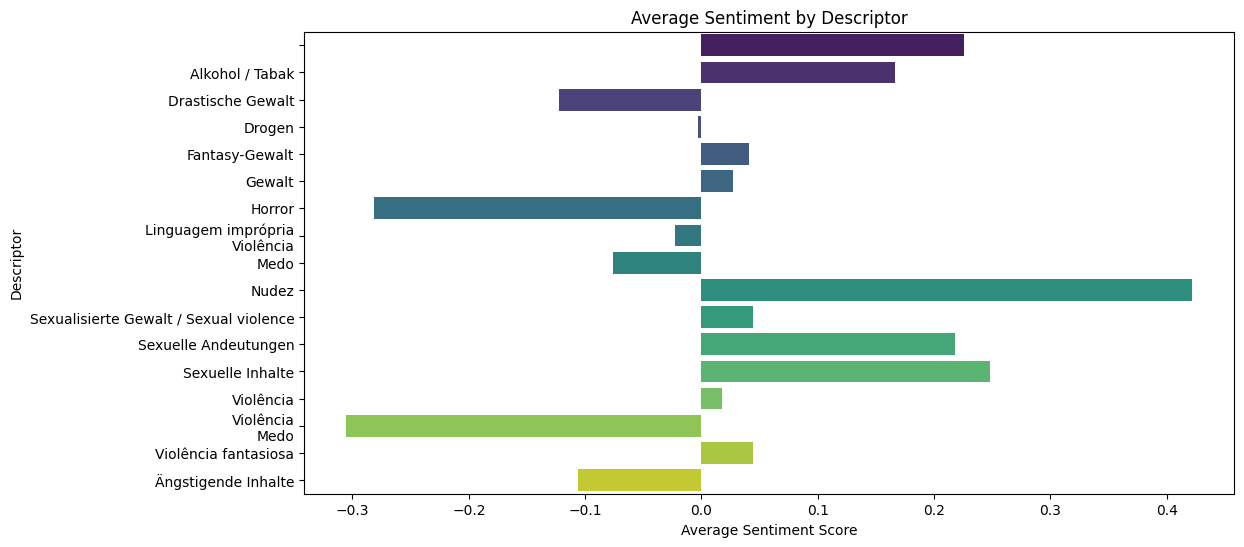

In [207]:

# Extract descriptors for sentiment analysis
def extract_descriptors(ratings):
    try:
        ratings_dict = ast.literal_eval(ratings)
        descriptors = []
        for key in ratings_dict.keys():
            if 'descriptors' in ratings_dict[key]:
                descriptors.extend(ratings_dict[key]['descriptors'].split(', '))
        return ', '.join(descriptors)
    except (ValueError, SyntaxError):
        return ''

df_selected.loc[:, 'descriptors'] = df_selected['ratings'].apply(extract_descriptors)

# Verify extraction
print("Extracted descriptors:")
print(df_selected['descriptors'].head())

# Split descriptors into separate words for analysis
df_selected.loc[:, 'descriptors_split'] = df_selected['descriptors'].str.split(', ')
df_exploded_descriptors = df_selected.explode('descriptors_split')

# Count descriptor frequencies
descriptor_counts = df_exploded_descriptors['descriptors_split'].value_counts()
print("Descriptor counts:")
print(descriptor_counts.head())

# Filter descriptors to include only those that occur at least 10 times
min_count = 100
filtered_descriptors = descriptor_counts[descriptor_counts >= min_count].index
df_filtered_descriptors = df_exploded_descriptors[df_exploded_descriptors['descriptors_split'].isin(filtered_descriptors)]

# Calculate average sentiment for each descriptor
descriptor_sentiment = df_filtered_descriptors.groupby('descriptors_split')['sentiment'].mean().reset_index()
descriptor_sentiment = descriptor_sentiment.rename(columns={'descriptors_split': 'descriptor', 'sentiment': 'average_sentiment'})

# Display the descriptor sentiment data
print("Descriptor sentiment data:")
print(descriptor_sentiment.head())

# Visualize the average sentiment by descriptor
plt.figure(figsize=(12, 6))
sns.barplot(y='descriptor', x='average_sentiment', data=descriptor_sentiment, palette='viridis')
plt.title('Average Sentiment by Descriptor')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Descriptor')
plt.show()